# Set up

In [87]:
# Libraries
import gurobipy as grb
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
model = grb.Model("Model")

# Load data

In [88]:
data_to_load = 'projet_example'     # 'toy' , 'medium', 'large' or 'projet_example' 

if data_to_load == 'projet_example' :
    p = 5     # nb de personnel
    n = 5     # nb de projet
    q = 3     # nb de qualification
    h = 12    # horizon temporel, nb de jour de projets

    # Données personnelles
    Q = [ [0,1], [2], [0], [1], [0,1,2]] #competences par personne
    V = [ [0, 5, 8], [], [], [], []] #congés par personne

    # Données des projets
    G =  [10, 10, 10, 10, 10]  #gain par projet
    P =  [1, 1, 1, 1, 1]       #penalite par projet et par jour de retard
    # nombre de jours par compétence par projet / ex : le projet 2 necessite 7 jours de travail sur la compétance C
    C = [[4,3,2],[3,2,7],[4,1,5],[3,3,3],[1,1,4]] 
    D = [3,5,8,9,11] # Deadline
    
else: 
    with open(f"./data/{data_to_load}_instance.json", "r") as f:
        data = json.load(f)

    p = len(data["staff"])              # nb de personnel
    n = len(data["jobs"])               # nb de projet
    q = len(data["qualifications"])     # nb de qualification
    h = data["horizon"]                 # horizon temporel, nb de jour de projets
    
    Q = []
    V = []
    for person in data['staff']:
        # 65 est le code ASCII de 'A'
        int_competences = [ ord(c) - 65 for c in person["qualifications"] ]
        Q.append(int_competences)
        V.append(person["vacations"])

    G = []
    P = []
    C = []
    D = []
    for job in data['jobs']:
        G.append(job['gain'])
        P.append(job['daily_penalty'])
        competences_nb = []
        for k in range(q) :
            if chr(65+k) in job['working_days_per_qualification']:
                competences_nb.append(job['working_days_per_qualification'][chr(65+k)])
            else:
                competences_nb.append(0)
        C.append(competences_nb)
        D.append(job["due_date"])

print('Nombre de personne : ', p)
print('Nombre de projet : ', n)
print('Nombre de compétences : ',q)
print('Horizon temporel : ',h)

print('Competences : ', Q)
print('Congés : ', V)
print('Competences par projet : ',C)
print('Deadline : ',D)

Nombre de personne :  5
Nombre de projet :  5
Nombre de compétences :  3
Horizon temporel :  12
Competences :  [[0, 1], [2], [0], [1], [0, 1, 2]]
Congés :  [[0, 5, 8], [], [], [], []]
Competences par projet :  [[4, 3, 2], [3, 2, 7], [4, 1, 5], [3, 3, 3], [1, 1, 4]]
Deadline :  [3, 5, 8, 9, 11]


# Decision Variables

In [89]:
X = model.addVars(p, n, q, h, vtype=GRB.BINARY)     
Y = model.addVars(n, vtype=GRB.BINARY)  # Le projet est-il complété en fin d'horizon temporel ?
L = model.addVars(n, vtype=GRB.INTEGER) # Jours de retard de chaque projets
E = model.addVars(n, lb = 0, ub = h-1, vtype=GRB.INTEGER)   # End dates

# Constraints

In [90]:
# Add constraints

no_ubiquity = []
for i in range(p):
    for t in range(h):
        no_ubiquity += [model.addConstr(sum(X[i, j, k, t] for j in range(n) for k in range(q)) <= 1)]

no_forced_work = []
for i in range(p):
    for t in V[i]:
        no_forced_work += [model.addConstr(sum(X[i, j, k, t] for j in range(n) for k in range(q)) == 0)]

end_of_poject = []
for j in range(n):
    for k in range(q):
        if C[j][k] > 0:
            end_of_poject += [model.addConstr( Y[j] * C[j][k] <= sum(X[i, j, k, t] for i in range(p) for t in range(h)))]

skill_constr = []
for i in range(p):
    for j in range(n):
        for k in range(q):
            for t in range(h):
                if (k not in Q[i]) or (C[j][k] == 0) :
                    skill_constr += [model.addConstr(X[i,j,k,t] == 0)]

no_overwork = []
for j in range(n):
    for k in range(q):
        no_overwork += [model.addConstr(sum(X[i, j, k, t] for i in range(p) for t in range(h)) <= C[j][k])]

model.addConstrs((X[i,j,k,t] * t <= E[j] for i in range(p) for j in range(n) for k in range(q) for t in range(h)))

model.addConstrs((E[j] - D[j] <= L[j] for j in range(n)))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

# Variables and Constraints  for multi criteria decision

#### Project duration 

In [91]:
B = model.addVars(n, lb = 0, ub = h-1, vtype=GRB.INTEGER)   # Begining dates

model.addConstrs(
    B[j] <= X[i, j, k, t] * t + (1 - X[i, j, k, t]) * h
    for i in range(p)
    for j in range(n) 
    for k in range(q)
    for t in range(h)    
)

model.addConstrs( B[j] <= E[j] for j in range(n))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

#### Number of project for people

In [92]:
R = model.addVars(p,n, vtype=GRB.BINARY)   # p a participé au projet n ?

for i in range(p):
    for j in range(n) :
        for k in range(q) :
            for t in range(h):
                model.addConstr(R[i,j] >= X[i, j, k, t] )


#### Get criteria value

In [93]:
def get_profit():
    return sum(Y[j].x * G[j] - L[j].x * P[j] for j in range(n))

def get_avg_project_duration():
    return 1 + sum(E[j].x - B[j].x for j in range(n)) / n

def get_avg_projects_per_person():
    return sum(R[i,j].x for i in range(p) for j in range(n)) / p 

# Optimization

### Optimization with various preferences in criteria 

In [94]:
model.update()
nb_points = 10
profits = []
avg_durations = []
avg_ppps = []

gain_obj = quicksum(Y[j] * G[j] - L[j] * P[j] for j in range(n))
duration_obj = quicksum((E[j] - B[j]) for j in range(n))
project_per_person_obj = quicksum(R[i,j] for i in range(p) for j in range(n))

for alpha in range(nb_points):
    alpha = alpha / (nb_points -1)

    # Nous donnons beaucoup de valeur au gain car nous estimons que c'est le critère le plus important
    # Voyons l'impact des poids attribués aux critères sur la durée et le nombre de personnes par projet
    
    model.setObjective(10 * gain_obj - alpha * duration_obj - (1-alpha) * project_per_person_obj , GRB.MAXIMIZE)
    model.optimize()

    profits.append(get_profit())
    avg_durations.append(get_avg_project_duration())
    avg_ppps.append(get_avg_projects_per_person())

print("\nOptimal objective value: ", int(model.ObjVal))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 3223 rows, 945 columns and 8525 nonzeros
Model fingerprint: 0xa00b57ee
Variable types: 0 continuous, 945 integer (930 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 2764 rows and 461 columns
Presolve time: 0.03s
Presolved: 459 rows, 484 columns, 2357 nonzeros
Variable types: 0 continuous, 484 integer (480 binary)

Root relaxation: objective 4.903125e+02, 935 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  490.31250    0  121   -0.00000  490.31250      -     -    0s
H    0     0                     195.0000000  490

#### Dominance graph

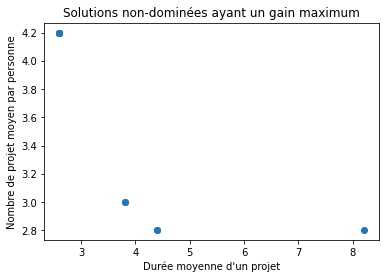

In [95]:
# Pour l'exmple du cours et nos critères, il n'y a que 4 solutions non dominées :
critere1 = [3.8, 3.8, 3.0, 4.2] 
critere2 = [8.2, 4.4, 3.8, 2.6]

plt.scatter(avg_durations, avg_ppps)
#plt.scatter(4,3.8)
plt.title("Solutions non-dominées ayant un gain maximum")
plt.xlabel("Durée moyenne d'un projet") 
plt.ylabel("Nombre de projet moyen par personne")
plt.show()

In [96]:
print("Profit  : \n", profits )
print("Durée moyenne : \n", avg_durations )
print("Nombre de projet moyen par personne : \n", avg_ppps )

print()

Profit  : 
 [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Durée moyenne : 
 [8.2, 4.4, 4.4, 3.8, 3.8, 2.6, 2.6, 2.6, 2.6, 2.6]
Nombre de projet moyen par personne : 
 [2.8, 2.8, 2.8, 3.0, 3.0, 4.2, 4.2, 4.2, 4.2, 4.2]



In [97]:
print("Profit d'une solution 'moyenne' : ", profits[int(nb_points/2)] )
print("Durée moyenne des projets d'une solution 'moyenne' : ", avg_durations[int(nb_points/2)] )
print("Nombre de projet moyen par personne d'une solution 'moyenne' : ", avg_ppps[int(nb_points/2)] )

Profit d'une solution 'moyenne' :  50.0
Durée moyenne des projets d'une solution 'moyenne' :  2.6
Nombre de projet moyen par personne d'une solution 'moyenne' :  4.2


# Affichage du planning

In [99]:
def days_list(h):
    L=[]
    for i in range(h):
        L.append('Jour '+str(i))
    return L

def person_list(i,X):
    L=[]
    listeria=[]
    for v in X.values():
        listeria.append(v.X)
    for day in range(h):
        c_day=""
        for projet in range(n):
            for qualif in range(q):
                if listeria[X[i, projet, qualif, day].index-X[0,0,0,0].index]==1:
                    c_day=(str(projet)+chr(65+qualif)) 
        L.append(c_day)
    return L

def show_planning(X):
    planning=pd.DataFrame(columns=days_list(h))
    for i in range(p):
        tt=pd.DataFrame([person_list(i,X)], columns=days_list(h), index=[i])
        planning=planning.append(tt)
    return planning

show_planning(X)

,Jour 0,Jour 1,Jour 2,Jour 3,Jour 4,Jour 5,Jour 6,Jour 7,Jour 8,Jour 9,Jour 10,Jour 11
0,,0A,,1B,1B,,2A,2B,,3B,4B,4A
1,0C,0C,1C,1C,1C,1C,2C,2C,3C,3C,4C,4C
2,0A,0A,1A,1A,1A,2A,2A,2A,3A,3A,,
3,0B,0B,,,,,,,3B,3B,,
4,0B,0A,1C,1C,1C,2C,2C,2C,3A,3C,4C,4C


#### Affichage par personne

In [49]:
for i in range(p):
    jours_travaille = 0
    print("\nEmploi du temps personne ",i, " : ")
    print("Nombre de projets : ", sum(R[i,j].x for j in range(n)) )
    for t in range(h):
        for k in range(q):
            for j in range(n):
                if X[i,j,k,t].x != 0:
                    jours_travaille += 1
                    print("Jour ", t, " Compétence ", k, " sur projet ", j)
    print("Jours travailés : ", jours_travaille)


Emploi du temps personne  0  : 
Nombre de projets :  3.0
Jour  1  Compétence  0  sur projet  1
Jour  2  Compétence  1  sur projet  1
Jour  3  Compétence  0  sur projet  1
Jour  4  Compétence  0  sur projet  1
Jour  6  Compétence  1  sur projet  2
Jour  7  Compétence  0  sur projet  2
Jour  9  Compétence  0  sur projet  4
Jour  10  Compétence  1  sur projet  4
Jours travailés :  8

Emploi du temps personne  1  : 
Nombre de projets :  4.0
Jour  0  Compétence  2  sur projet  1
Jour  1  Compétence  2  sur projet  1
Jour  2  Compétence  2  sur projet  1
Jour  3  Compétence  2  sur projet  1
Jour  4  Compétence  2  sur projet  1
Jour  5  Compétence  2  sur projet  3
Jour  6  Compétence  2  sur projet  3
Jour  7  Compétence  2  sur projet  2
Jour  8  Compétence  2  sur projet  2
Jour  9  Compétence  2  sur projet  4
Jour  10  Compétence  2  sur projet  4
Jours travailés :  11

Emploi du temps personne  2  : 
Nombre de projets :  3.0
Jour  0  Compétence  0  sur projet  0
Jour  1  Compétence  

#### Affichage par projet

In [52]:
for j in range(n):
    print("\nAllocation pour le projet ",j, " : ")
    print("Durée du projet : ", 1 + E[j].x - B[j].x )
    for k in range(q):
        for i in range(p):
            for t in range(h):
                if X[i,j,k,t].x != 0:
                    print(" Compétence ", k, " par personne ", i, " Jour ", t)

print("Durée moyenne des projets : ", 1 + sum(E[j].x - B[j].x for j in range(n)) / n)


Allocation pour le projet  0  : 
Durée du projet :  3.0
 Compétence  0  par personne  2  Jour  0
 Compétence  0  par personne  2  Jour  1
 Compétence  0  par personne  2  Jour  2
 Compétence  0  par personne  4  Jour  1
 Compétence  1  par personne  3  Jour  0
 Compétence  1  par personne  3  Jour  1
 Compétence  1  par personne  3  Jour  2
 Compétence  2  par personne  4  Jour  0
 Compétence  2  par personne  4  Jour  2

Allocation pour le projet  1  : 
Durée du projet :  5.0
 Compétence  0  par personne  0  Jour  1
 Compétence  0  par personne  0  Jour  3
 Compétence  0  par personne  0  Jour  4
 Compétence  1  par personne  0  Jour  2
 Compétence  1  par personne  3  Jour  4
 Compétence  2  par personne  1  Jour  0
 Compétence  2  par personne  1  Jour  1
 Compétence  2  par personne  1  Jour  2
 Compétence  2  par personne  1  Jour  3
 Compétence  2  par personne  1  Jour  4
 Compétence  2  par personne  4  Jour  3
 Compétence  2  par personne  4  Jour  4

Allocation pour le proje

In [57]:
print(B[j].x for j in range(n))

<generator object <genexpr> at 0x7fa10b30cc50>


# Categorisation of a given planning

In [24]:
def get_profit_d():
    return sum(Y[j] * G[j] - L[j] * P[j] for j in range(n))

def get_avg_project_duration_d(X):
    return 1 + sum(E[j] - B[j] for j in range(n)) / n

def get_avg_projects_per_person_d(X):
    return sum(R[i,j] for i in range(p) for j in range(n)) / p   

In [28]:
X_decideur = [ X[i,j,k,t].x for i in range(p) for j in range(n) for k in range(q) for t in range(h) ]

def planning_categorisation(X_decideur):

    profit_d = get_profit_d(X_decideur)
    avg_duration_d = get_avg_project_duration_d(X_decideur)
    avg_ppp_d = get_avg_projects_per_person_d(X_decideur)

    if profit_d == max(profits):
        for k in range(nb_points):
            if avg_durations[k] < avg_duration_d:
                if avg_ppps[k] < avg_ppp_d:
                    print("Planning inacceptable car dominé par le point : ", k)
                    return 2
        print("Planning est satisfaisant")
        return 0
    for k in range(nb_points):
        if avg_durations[k] <= avg_duration_d:
            if avg_ppps[k] <= avg_ppp_d:
                print("Planning inacceptable car dominé par le point : ", k)
                return 2
    print("Planning correct car n'est pas dominé, cepandant son gain n'est pas maximum")
    return 1



In [ ]:
def show_X_decideur_on_domination_graph(X_decideur, categorisation = ""):
    profit_d = get_profit(X_decideur)
    avg_duration_d = get_avg_project_duration(X_decideur)
    avg_ppp_d = get_avg_projects_per_person(X_decideur)

    plt.scatter(avg_durations, avg_ppps)
    plt.scatter(avg_duration_d, avg_ppp_d)
    plt.xlabel("Nombre de projet moyen par personne")
    plt.ylabel("Durée moyenne d'un projet")
    plt.show()
        

# Affichage du planning

#### Affichage par personne

In [44]:
for i in range(p):
    jours_travaille = 0
    print("\nEmploi du temps personne ",i, " : ")
    print("Nombre de projets : ", sum(R[i,j].x for j in range(n)) )
    for t in range(h):
        for k in range(q):
            for j in range(n):
                if X[i,j,k,t].x != 0:
                    jours_travaille += 1
                    print("Jour ", t, " Compétence ", k, " sur projet ", j)
    print("Jours travailés : ", jours_travaille)


Emploi du temps personne  0  : 
Nombre de projets :  3.0
Jour  1  Compétence  0  sur projet  1
Jour  2  Compétence  1  sur projet  1
Jour  3  Compétence  0  sur projet  1
Jour  4  Compétence  0  sur projet  1
Jour  6  Compétence  1  sur projet  2
Jour  7  Compétence  0  sur projet  2
Jour  9  Compétence  0  sur projet  4
Jour  10  Compétence  1  sur projet  4
Jours travailés :  8

Emploi du temps personne  1  : 
Nombre de projets :  4.0
Jour  0  Compétence  2  sur projet  1
Jour  1  Compétence  2  sur projet  1
Jour  2  Compétence  2  sur projet  1
Jour  3  Compétence  2  sur projet  1
Jour  4  Compétence  2  sur projet  1
Jour  5  Compétence  2  sur projet  3
Jour  6  Compétence  2  sur projet  3
Jour  7  Compétence  2  sur projet  2
Jour  8  Compétence  2  sur projet  2
Jour  9  Compétence  2  sur projet  4
Jour  10  Compétence  2  sur projet  4
Jours travailés :  11

Emploi du temps personne  2  : 
Nombre de projets :  3.0
Jour  0  Compétence  0  sur projet  0
Jour  1  Compétence  

#### Affichage par projet

In [38]:
for j in range(n):
    print("\nAllocation pour le projet ",j, " : ")
    print("Durée du projet : ", 1 + E[j].x - B[j].x )
    for k in range(q):
        for i in range(p):
            for t in range(h):
                if X[i,j,k,t].x != 0:
                    print(" Compétence ", k, " par personne ", i, " Jour ", t)

print("Durée moyenne des projets : ", 1 + sum(E[j].x - B[j].x for j in range(n)) / n)


Allocation pour le projet  0  : 
Durée du projet :  3.0
 Compétence  0  par personne  2  Jour  0
 Compétence  0  par personne  2  Jour  1
 Compétence  0  par personne  2  Jour  2
 Compétence  0  par personne  4  Jour  1
 Compétence  1  par personne  3  Jour  0
 Compétence  1  par personne  3  Jour  1
 Compétence  1  par personne  3  Jour  2
 Compétence  2  par personne  4  Jour  0
 Compétence  2  par personne  4  Jour  2

Allocation pour le projet  1  : 
Durée du projet :  5.0
 Compétence  0  par personne  0  Jour  1
 Compétence  0  par personne  0  Jour  3
 Compétence  0  par personne  0  Jour  4
 Compétence  1  par personne  0  Jour  2
 Compétence  1  par personne  3  Jour  4
 Compétence  2  par personne  1  Jour  0
 Compétence  2  par personne  1  Jour  1
 Compétence  2  par personne  1  Jour  2
 Compétence  2  par personne  1  Jour  3
 Compétence  2  par personne  1  Jour  4
 Compétence  2  par personne  4  Jour  3
 Compétence  2  par personne  4  Jour  4

Allocation pour le proje

# Annexe

In [141]:
model.setObjectiveN(quicksum(Y[j] * G[j] - L[j] * P[j] for j in range(n)), 0, 1)
model.setObjectiveN(- quicksum(E[j] - B[j] for j in range(n)), 1, 0)
model.ModelSense = GRB.MAXIMIZE
model.update()
model.optimize()